# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates


In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        model_final = copy.deepcopy(pipe)
        model_final.set_params(**best_params)
        model_final.fit(X_train, y_train.values.ravel())
    else:
        model_final = None

    return score, best_params, model_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [12]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [13]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [14]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])
query = "select * from all_scr_preadmission_75_JOIN_6hr_fix"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [15]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


## Rename columns

In [16]:
data.rename(columns={
'egfr_epi_scr_max':'eGFR',
'pt_max':'Prothrombin time',
'invasive_vent':'invasive ventilation',
'congestive_heart_failure':'congestive heart failure',
'diabetes_type2':'diabetes Type2',
'resp_rate_max':'respiratory rate max',
'sbp_max':'systolic blood pressure max',
'heart_rate_max':'heart rate max',
'dbp_max':'diastolic blood pressure max',
'spo2_min':'oxygen saturation min',
'spo2_max':'oxygen saturation max',
'bicarbonate_max':'bicarbonate max',
'bicarbonate_min':'bicarbonate min',
'ckd':'chronic kidney disease',
'wbc_max':'white blood count max',
'wbc_min':'white blood count min',
'bun_min':'blood urine nitrogen min',
'creatinine_min':'creatinine min',
'creatinine_max':'creatinine max',
'hematocrit_min':'hematocrit min',
'sodium_max':'sodium max',
'chloride_max':'chloride max',
'hemoglobin_min':'hemoglobin min',
'aniongap_max':'aniongap max',
'supplemental_oxygen':'supplemental Oxygen',
'calcium_max':'calcium max',
'urineoutput_24hr':'urine output',
'myocardial_infarct':'myocardial infarction',
'aniongap_min':'aniongap min',
'calcium_min':'calcium min'
}, inplace=True)

## Remove useless columns

In [17]:
drop_X   = [
'potassium_min',
'temperature_min',
'glucose_max',
'glucose_min',
'sodium_min',
'temperature_mean',
'egfr_mdrd_scr_max',
'pt_min',
'inr_min',
'inr_max',
'weight_admit',
'weight_min',
'ptt_max',
'ptt_min',
'platelets_max',
'resp_rate_min',
'resp_rate_mean',
'sbp_mean',
'sbp_min',
'chloride_min',
'heart_rate_mean',
'heart_rate_min',
'dbp_min',
'dbp_mean',
'non_invasive_vent',
'wbc_bd_min',
'wbc_bd_max',
'chronic_kidney_disease',
'arbs_acei',
'hematocrit_max',
'bun_max'
]


data.drop(drop_X, inplace=True, axis=1)

In [18]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')

outcome_var = ['day_detection_kdigo_grade_1']

first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [19]:
data.shape

(30430, 80)

In [20]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [21]:
data = data[data['kidney_transplant']==0]

In [22]:
# data = data[data['egfr_mdrd_scr']>60]

In [23]:
# data[data.egfr_mdrd_scr<60].shape

In [24]:
data_tmp = data.copy()

In [25]:
data.head(5)

,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,chronic kidney disease,is_mdrd,egfr_epi_scr,egfr_mdrd_scr,kidney_transplant,congestive heart failure,diabetes Type2,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial infarction,chronic_pulmonary_disease,chronic_heart_failure,sepsis,hematocrit min,hemoglobin min,hemoglobin_max,platelets_min,white blood count min,white blood count max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap min,aniongap max,bicarbonate min,bicarbonate max,blood urine nitrogen min,calcium min,calcium max,chloride max,creatinine min,creatinine max,sodium max,potassium_max,Prothrombin time,thrombin_min,thrombin_max,bilirubin_total_min,bilirubin_total_max,eGFR,heart rate max,systolic blood pressure max,diastolic blood pressure max,respiratory rate max,temperature_max,oxygen saturation min,oxygen saturation max,cyclosporine,bmi,urine output,supplemental Oxygen,invasive ventilation,hfnc,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_max,hospital_expire_flag
stay_id,subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30283046,10777271,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,54.0,0,NaN,0,1,62.0,58.0,0,0,0,1,0,0,0,0,0,0,0,0,0,41.0,13.7,14.7,179.0,13.6,15.3,3.5,3.5,NaN,NaN,NaN,NaN,12.0,14.0,20.0,22.0,10.0,7.0,8.0,116.0,1.2,1.3,146.0,3.4,11.3,NaN,NaN,0.2,0.2,62.0,101.0,143.0,100.0,23.0,39.00,95.0,100.0,0,NaN,1500.0,0,0,0,0,99999999.0,99999999.0,83.5,0
36223916,10135398,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,59.0,0,WHITE,0,1,75.0,71.0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.8,10.8,13.3,135.0,6.8,9.2,4.0,4.0,NaN,NaN,NaN,NaN,16.0,23.0,20.0,26.0,7.0,7.6,8.3,104.0,0.6,0.8,144.0,3.8,12.6,NaN,NaN,1.3,1.3,98.0,127.0,166.0,106.0,28.0,38.39,91.0,100.0,0,49.04,675.0,0,0,0,0,99999999.0,99999999.0,87.3,0
39625809,19016548,1,0,0,2.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,42.0,0,NaN,0,1,67.0,61.0,0,1,1,0,0,0,0,1,0,1,0,1,1,25.0,7.9,7.9,194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,23.0,23.0,55.0,8.0,8.0,95.0,1.0,1.0,131.0,4.7,17.7,NaN,NaN,1.1,1.1,92.0,131.0,147.0,59.0,25.0,39.00,95.0,100.0,0,52.20,550.0,0,1,0,0,99999999.0,99999999.0,90.3,1
37944322,12187566,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,68.0,1,NaN,0,1,66.0,62.0,0,0,0,1,0,0,0,0,0,0,0,0,0,26.0,8.7,10.6,96.0,11.0,17.9,NaN,NaN,NaN,NaN,NaN,NaN,7.0,12.0,19.0,26.0,8.0,NaN,NaN,109.0,0.7,0.9,139.0,NaN,16.9,NaN,NaN,NaN,NaN,66.0,104.0,127.0,80.0,24.0,37.22,94.0,100.0,0,53.73,275.0,1,1,0,0,99999999.0,99999999.0,96.1,0
33754541,19510789,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,85.0,1,NaN,0,1,51.0,53.0,0,0,0,1,0,1,0,0,0,0,1,0,0,37.8,12.3,12.3,158.0,6.7,6.7,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,24.0,24.0,22.0,9.5,9.5,108.0,0.9,0.9,144.0,4.2,11.0,NaN,NaN,NaN,NaN,58.0,79.0,160.0,104.0,26.0,37.22,93.0,98.0,0,NaN,400.0,0,0,0,0,99999999.0,99999999.0,45.6,0


In [26]:
data.shape

(30269, 80)

In [27]:
data.dropna(axis=1, thresh = int(0.8*data.shape[0]), inplace=True)

In [28]:
# pd.set_option('display.max_rows', None)

In [29]:
# data.isna().sum()/len(data)*100

In [30]:
# prediction_window = 3

# data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
#     &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
#         |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


# data.loc[data.outcome.isna(),'outcome']=0

In [31]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [32]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
# 'ckd',
# 'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [33]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [34]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [35]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [36]:
# data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
#                                             .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
#                                             .fillna('other').pipe(onehot)
data_cat = data_cat.fillna('other').pipe(onehot)

In [37]:
data_cat.head(5)

len                                               \
variable            ethnicity                                                
value                   ASIAN BLACK/AFRICAN AMERICAN HISPANIC/LATINO WHITE   
stay_id  subject_id                                                          
30000153 12466550           0                      0               0     1   
30001148 12980335           0                      0               0     0   
30001336 12168737           0                      0               0     0   
30001656 19609454           0                      0               0     1   
30001947 15904173           0                      0               0     1   

                           
variable                   
value               other  
stay_id  subject_id        
30000153 12466550       0  
30001148 12980335       1  
30001336 12168737       1  
30001656 19609454       0  
30001947 15904173       0

In [38]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [39]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

61.2706068915392

In [40]:
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)

In [41]:
processed.aki_kdigo_grade_1.value_counts()


0    25212
1     5057
Name: aki_kdigo_grade_1, dtype: int64

In [42]:
processed.aki_kdigo_grade_2.value_counts()

0    29609
1      660
Name: aki_kdigo_grade_2, dtype: int64

In [43]:
processed.aki_kdigo_grade_3.value_counts()

0    30138
1      131
Name: aki_kdigo_grade_3, dtype: int64

In [44]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',

    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [45]:
df_X.shape

(30269, 56)

In [46]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split


X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) # 

X_train, X_valid, y_train, y_valid = train_test_split(X_train_0, y_train_0, test_size=0.2, random_state=42, shuffle=True, stratify=y_train_0)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [47]:
# X_train, y_train = df_X, df_y
X_train, y_train = up_sample(X_train, y_train,'outcome')

In [48]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [49]:
df_y.value_counts()

outcome
0.0        25212
1.0         5057
dtype: int64

___________________
### Define pipeline

In [50]:
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

___________________
### Cross validation search

In [51]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid = {
#     'model__n_estimators': [100, 500 ],
#     'model__max_depth': [ 30 , 40, 50 , 60 , 80, 100],
#     'model__min_samples_leaf': [100, 70, 50,20, 10,5],
#     'model__min_samples_split' : [100, 70, 50,20, 10,5]
# }

# # param_grid ={'model__max_depth': [6, 10], 
# #    }




# score, best_params, model_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(model_final , open('model_final_LGBM.pkl', 'wb'))

__________
### Fitting Pipeline one time



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



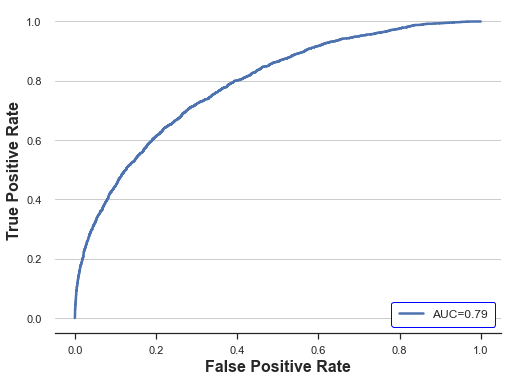

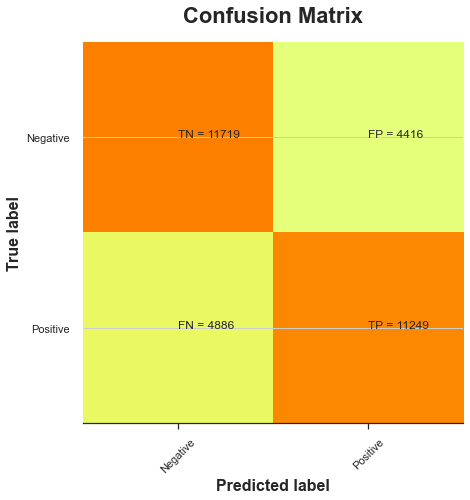


Classification report

              precision    recall  f1-score   support

         0.0       0.71      0.73      0.72     16135
         1.0       0.72      0.70      0.71     16135

    accuracy                           0.71     32270
   macro avg       0.71      0.71      0.71     32270
weighted avg       0.71      0.71      0.71     32270


_________________________________________

Specificity

0.73

_________________________________________


In [52]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}
plt.rcParams["figure.figsize"] = (8,6)

best_params2 = {'model__n_estimators':100,'model__max_depth': 100
,'model__min_samples_leaf': 300, 'model__min_samples_split': 200}



# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

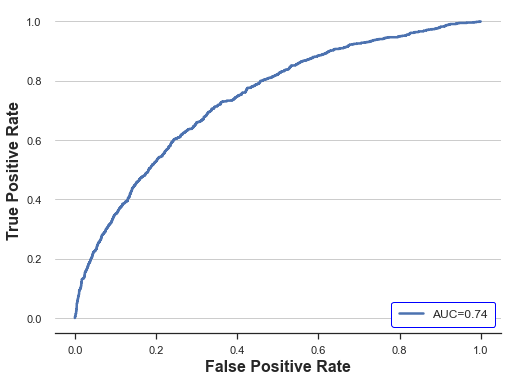

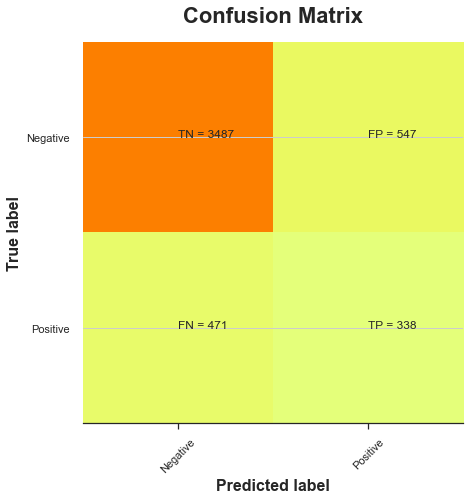


Classification report

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      4034
         1.0       0.38      0.42      0.40       809

    accuracy                           0.79      4843
   macro avg       0.63      0.64      0.64      4843
weighted avg       0.80      0.79      0.79      4843


_________________________________________

Specificity

0.86

_________________________________________


In [53]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (8,6)

X,y = X_valid.values, y_valid.values

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.59).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [54]:
df_y.value_counts()

outcome
0.0        25212
1.0         5057
dtype: int64

In [55]:
# fpr_RF_grade123, tpr_RF_grade123, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
# %store fpr_RF_grade123
# %store tpr_RF_grade123

In [59]:
def scale_impute(df, pipe):
    data_scaled = pipe.named_steps['scaler'].transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    data_imputed = pipe.named_steps['imputer'].transform(df_scaled)
    df_result = pd.DataFrame(data_imputed, columns=df.columns)
    return df_result


X_train_t = scale_impute(df=X_train,pipe=model_final)
X_valid_t = scale_impute(df=X_valid,pipe=model_final)
X_test_t = scale_impute(df=X_test,pipe=model_final)

Stored 'fop_rf_bl3' (ndarray)
Stored 'mpv_rf_bl3' (ndarray)


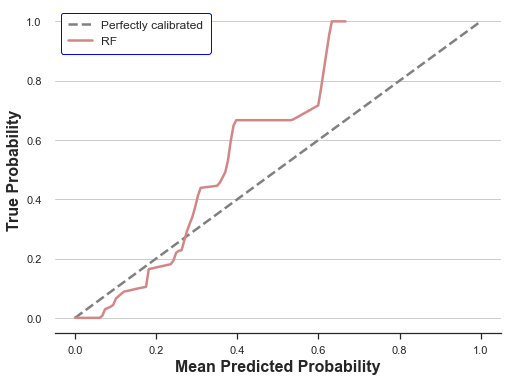

Expected Calibration Error (ECE): 0.1092
Brier Score: 0.1217


In [82]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from matplotlib import pyplot
import lightgbm as lgbm
from scipy.interpolate import interp1d
from sklearn.metrics import brier_score_loss



# WITH TUNING


# model_with_tunning = pipeline_final._final_estimator

# calibrated = CalibratedClassifierCV(model_with_tunning, method='sigmoid', cv=5)
# calibrated.fit(X_train, y_train)

# #  predict probabilities
# probs = calibrated.predict_proba(X_valid)[:, 1]
# # reliability diagram
# fop, mpv = calibration_curve(y_valid, probs, n_bins=20, strategy='uniform')


# fop = np.sort(fop)
# mpv = np.sort(mpv)

# cubic_interpolation_model = interp1d(mpv, fop, kind = "cubic")

# # Plotting the Graph
# X_with_tuning_=np.linspace(mpv.min(), mpv.max(), 50)
# Y_with_tuning_=cubic_interpolation_model(X_with_tuning_)






## NO TUNING

# model = model_final._final_estimator

# model = RandomForestClassifier(random_state=42, n_jobs=-1)

model = model_final._final_estimator


calibrated = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
calibrated.fit(X_valid_t,  y_valid)

#  predict probabilities
probs = calibrated.predict_proba(X_test_t)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=100, strategy='uniform')

ece = np.abs(fop - mpv).mean()

# Calculate Brier score
brier_score = brier_score_loss(y_test, probs)


fop = np.sort(fop)
mpv = np.sort(mpv)

cubic_interpolation_model = interp1d(mpv, fop, kind = "slinear")

# Plotting the Graph
fop_rf_bl3=np.linspace(mpv.min(), mpv.max(), 100)
mpv_rf_bl3=cubic_interpolation_model(fop_rf_bl3)

%store fop_rf_bl3

%store mpv_rf_bl3

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
# plot calibrated reliability
# pyplot.plot(X_with_tuning_, Y_with_tuning_, color='#D18787', label='Calibrated with tunning')
# pyplot.plot(X_, Y_, color='#66CC', label='XGB')
pyplot.plot(fop_rf_bl3, mpv_rf_bl3, color='#D18787', label='RF')

pyplot.xlabel('Mean Predicted Probability')
pyplot.ylabel('True Probability')
pyplot.legend()
# pyplot.savefig('Calibration_XGB_bl3.jpg', dpi=300) 
pyplot.show()

print("Expected Calibration Error (ECE):", round(ece,4))
print("Brier Score:", round(brier_score, 4))


In [83]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming you have the predicted probabilities stored in 'y_pred' and the true labels in 'y_true'

# Compute the calibration curve
true_probs, pred_probs = fop, mpv

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(pred_probs.reshape(-1, 1), true_probs)

# Extract the slope coefficient
calibration_slope = regression_model.coef_[0]

print("Calibration Slope:", calibration_slope)


Calibration Slope: 1.5851983233179832


In [86]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


X,y = X_test.values, y_test.values

# Define the threshold range
threshold_range = np.arange(0.2, 0.3, 0.0001)

best_f1_score = 0
best_precision = 0
best_recall = 0
best_threshold = 0

# Iterate through the threshold range
for threshold in threshold_range:
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Update the best threshold if necessary
    if f1 > best_f1_score:
        best_f1_score = f1
        best_precision = precision
        best_recall = recall
        best_threshold = threshold

# Output the best threshold and its corresponding precision, recall, and F1 score
print("Best Threshold:", best_threshold)
print("Precision:", best_precision)
print("Recall:", best_recall)
print("F1 Score:", best_f1_score)


Best Threshold: 0.2
Precision: 0.3310344827586207
Recall: 0.6172106824925816
F1 Score: 0.430939226519337


: 

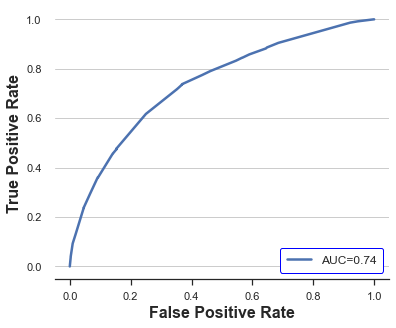

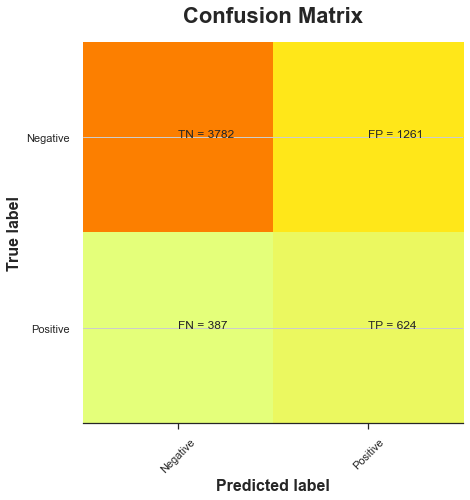


Classification report

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      5043
         1.0       0.33      0.62      0.43      1011

    accuracy                           0.73      6054
   macro avg       0.62      0.68      0.63      6054
weighted avg       0.81      0.73      0.76      6054


_________________________________________

Specificity

0.75

_________________________________________


In [85]:
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.2

X_test_t = scale_impute(df=X_test,pipe=model_final)


X,y = X_test_t.values, y_test.values
# X,y = X_test.values, y_test.values

y_pred = calibrated.predict(X)
y_pred_proba = calibrated.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)